Importing packages

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.pyplot import cm
from matplotlib import pyplot as plt


import numpy as np

Setting up background functions

In [2]:
### Function generateTargetFunction(order, numSamps=10, **kwargs)
## Generates a polynomial target function based on the parameters 
## passed to it
##  
##  Parameters:
##      order: [integer] The polynomial order of the target function 
##                       (0th order is just a constant, 2nd order is 
##                       a quadratic, etc.)
##      numSamps (10): [integer] The number of samples to generate from
##                                 the target function
##      randCoeffs (True): [Boolean] Whether the coefficients should
##                                   be generated randomly or not. 
##                                   If set to false, the coefficients 
##                                   parameter must be a list of length 
##                                   matching the order parameter, 
##                                   containing real numbers to be used 
##                                   as the coefficients of the polynomial
##      coefficients: [list] Only used when the randCoeffs parameter is
##                           False. Allows manually setting the coefficients
##                           of the target function. Must be a list of real
##                           numbers
##      x_dist ('normal'): [string] A string specifying the sampling 
##                                  distribution of the x_values. 
##                                  Several other parameters will
##                                  be used or ignored depending on
##                                  this parameter (specifically 'x_mean', 
##                                  'x_std' will be used if x_dist='norm', 
##                                  and 'x_ub', 'x_lb' will be used
##                                  if x_dist='uniform')
##                                  Options are {'normal', 'uniform'}
##      x_mean (0): [int/float] Mean of the distribution to be used for 
##                            generating the samples of x (the target values
##                            input to the target function). Will only be used
##                            if x_dist='normal'
##      x_std (1): [int/float] Standard deviation of the distribution to
##                             be used for generating the samples of x 
##                             (see "x_mean" for better description of x).
##                             Will only be used if x_dist='normal'
##      x_lb (0): [int/float] Lower bound of the x-values to be generated
##                            from the uniform distribution. Will only
##                            be used if x_dist='uniform'
##      x_ub (10): [int/float] Upper bound of the x-values to be generated
##                             from the uniform distribution. Will only
##                             be used if x_dist='uniform'
##      noise_mean (0): [int/float] Mean of the noise term (epsilon)
##      noise_std (1): [int/float] Standard deviation of the noise term (epsilon).
##                                 If this is set to be less than or equal 
##                                 to 0, then no noise will be added to the 
##                                 target function
##      rngSeed (-1): [int] The seed used to initialize and specify the random state.
##                       If rngSeed < 0, then the seed will not be set.
##                       For more information about this see: https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.seed.html
##                                  
##  Outputs: returnData
##      returnData: [dict] Dictionary with keys ('x_data', 'y_data', 'coeffs')
##              returnData['x_data']: [numpy array {numSamps by 1}] X values generated from
##                                                                  a normal distribution plugged
##                                                                  into the target function
##              returnData['y_data']: [numy array {numSamps by 1}] Y values associated with the
##                                                                 x values from the target function
##              returnData['coeffs']: [numpy array {order by 1}] The coefficients of the target function
def generateTargetFunction(order, numSamps=10, **kwargs):

    # This is just to make this function line up with scikit learns polynomial fit
    # function, so that a 0th order function is just a constant, 
    # a 1st order function is an affine function, and a 2nd order
    # function is a function with an intercept, a linear component
    # and a quadratic term
    order = order + 1

    returnData = dict()

    # Setting the seed only if it was passed, and only if the parameter is greater than 0
    if('rngSeed' in kwargs):
        if(not kwargs['rngSeed'] < 0):
            np.random.seed(seed=kwargs['rngSeed'])
    
    if(not 'randCoeffs' in kwargs):
        randCoeffs = True
    else:
        randCoeffs = kwargs['randCoeffs']

    if(randCoeffs == False):
        # Need to check if the coefficients variable is set
        # and then if the coefficients variable
        # is the right length
        if(not 'coefficients' in kwargs.keys()):
            raise Exception('"randCoeffs" set to False, but "coefficients" parameter not set')
        elif(not len(kwargs['coefficients']) == order):
            raise Exception('"coefficients" parameter does not have length equal to "order"')
        elif(not all(isinstance(x, (int, float) ) for x in  kwargs['coefficients']) ):
            raise Exception('"coefficients" parameter contains non-numerics')
        
        # If we got this far, that means we have the coefficients given to us already
        coeffs = np.array(kwargs['coefficients'])

    else:
        # randomly generating the coefficients from a normal(0,1) dist.
        coeffs = np.random.normal(loc=0, scale=1, size=order)
    
    
    ## Defaulting parameters

    # Checking what x_dist is set to and then defaulting parameters appropriately
    if(not 'x_dist' in kwargs.keys()):
        x_dist = 'normal'
    else:
        x_dist = kwargs['x_dist']
    
    # Checking the x_dist parameter and defaulting parameters based on this
    if(x_dist == 'normal'):
        if(not 'x_mean' in kwargs.keys()):
            x_mean = 0
        else:
            x_mean = kwargs['x_mean']
        if(not 'x_std' in kwargs.keys()):
            x_std = 1
        else:
            x_std = kwargs['x_std']
    elif(x_dist == 'uniform'):
        if(not 'x_lb' in kwargs.keys()):
            x_lb = 0
        else:
            x_lb = kwargs['x_lb']
        
        if(not 'x_ub' in kwargs.keys()):
            x_ub = 10
        else: 
            x_ub = kwargs['x_ub']
    # Only get here if the x_dist parameter was set but wasn't one of the two allowable options
    else:
        if(not isinstance(kwargs['x_dist'], str)):
            raise Exception('x_dist was set to a non-string value')
        else:

            raise Exception('Parameter passed in for x_dist was: ' + kwargs['x_dist'] + '. Which is not a viable distribution, it should be one of [\'normal\', \'uniform\']')

    if(not 'noise_mean' in kwargs.keys()):
        noise_mean = 0
    else:
        noise_mean = kwargs['noise_mean']

    if(not 'noise_std' in kwargs.keys()):
        noise_std = 1
    else:
        noise_std = kwargs['noise_std']

    if(x_dist == 'normal'):
        rng = np.random.default_rng()
        # Generating the x-values to go with the samples from a normal dist.
        x_values = rng.normal(loc=x_mean, scale=x_std, size=numSamps).reshape(numSamps, 1)
    elif(x_dist == 'uniform'):
        rng = np.random.default_rng()
        # Generating the x-values to go with the samples from a continuous uniform dist.
        x_values = rng.uniform(low=x_lb, high=x_ub, size=numSamps).reshape(numSamps, 1)
    
    # Setting up the y_values and the noise term
    y_values = np.zeros((numSamps, 1))


    if(noise_std <= 0):
        noiseValues = np.zeros((numSamps, 1))
    else:
        noiseValues = np.random.normal(loc=noise_mean, scale=noise_std, size=numSamps).reshape(numSamps, 1)

    y_values = y_values + noiseValues

    # Looping over for each of the elements of the coefficients, to generate the samples from that order
    currentOrder = 0
    for i in coeffs:
        y_values = y_values + ((x_values**currentOrder) * coeffs[currentOrder]).reshape(numSamps, 1)
        currentOrder = currentOrder + 1
    
    returnData['x_values'] = x_values
    returnData['y_values'] = y_values
    returnData['coeffs'] = coeffs
    
    return(returnData)



### Function generatePlottableValues(polyCoeffs, x_lowerBound=0, x_upperBound=1, stepSize=0.01)
## Generates x and y values appropriate for
## plotting the polynomial function whos coefficients 
## are passed to it
##
##  Parameters: 
##      polyCoeffs: [list] List of numeric values corresponding to the
##                         coefficients of the polynomial to be plotted
##      x_lowerBound (0): [int/float] Lower bound of the x values to
##                                    generate (i.e. farthest left x-value
##                                    that you want plotted)
##      x_upperBound (1): [int/float] Upper bound of the x values to 
##                                    generate (i.e. farthest right x-value
##                                    that you want plotted)
##      stepSize (0.01): [int/float] The size of the steps to make between
##                                   the lowerbound for x and the upperbound.
##                                   the number of x & y values generated will 
##                                   be: (x_upperBound - x_lowerBound) / stepSize
##
##  Outputs: (plottableXValues, plottableYValues)
##      plottableXValues: [list] List of numeric values that are the x-values
##                               that are meant to be plotted
##      plottableYValues: [list] List of numeric values that are the y-values
##                               that are meant to be plotted (based on the 
##                               x-values and polynomial coefficients)
def generatePlottableValues(polyCoeffs, x_lowerBound=0, x_upperBound=1, stepSize=0.01):
    plottableXValues = np.arange(x_lowerBound, x_upperBound, step=stepSize)
    plottableYValues = np.zeros((len(plottableXValues)))

    curOrder = 0
    for curCoeff in polyCoeffs:
        plottableYValues = plottableYValues + (curCoeff * (plottableXValues**curOrder))
        curOrder = curOrder + 1
    return(plottableXValues, plottableYValues)



### fitPolynomialRegressionLine(xVals, yVals, degree=1)
## Function that fits a polynomial regression line of
## degree 'degree' to the xVals and yVals passed to it
##
##  Parameters: 
##      xVals: [list] A list of numeric values that are the
##                    'features' to train the regression line
##                    on
##      yVals: [list] A list of numeric values that are
##                    the true values you want to predict
##                    or estimate
##      degree (1): [int] The degree of the polynomial that
##                        will be fit to the data
##
##  Outputs: (regressionCoeffs, regressionObject)
##      regressionCoeffs: [list] A list of numeric values that 
##                               are the coefficients of the 
##                               polynomial regression line
##      polyRegressionObject: [sklearn.linear_model] The scikit-learn linear regression object that serves as our polynomial regression model. 
##                                               See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
##                                               for more details
def fitPolynomialRegressionLine(xVals, yVals, degree=1):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(xVals)

    # Create the polynomial regression object
    polyRegressionObject = LinearRegression()
    polyRegressionObject.fit(x_poly, yVals)

    # Get the coefficients of the polynomial regression
    regressionCoeffs = polyRegressionObject.coef_[0]
    regressionCoeffs[0] = polyRegressionObject.intercept_

    return(regressionCoeffs, polyRegressionObject)



## Function testPolynomialRegression(xVals, yVals, polyRegressionObject)
## A function to make a prediction of the yVals given the xVals, and 
## a polynomial scikit-learn regression object
##
## Parameters: 
##      xVals: [list] A list of numeric values that are the x-values
##                    to make predictions on
##      yVals: [list] A list of numeric values that correspond to the
##                    true values corresponding to the x-values
##      polyRegressionObject: [sklearn.linear_model] A scikit-learn linear regression model that is the polynomial regression function
##                                                   that we will be using to make predictions of the y-values from the x-values.
##                                                   See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
##                                                   for more details
##
## Outputs: (predictedValues, residuals, regressionMSE)
##      predictedValues: [list] A list of numeric values that are the predictions of the y-values
##                              that the polynomial regression line found from the x-values
##      residuals: [list] A list of numeric values that are the differences between the 
##                        true y-values and our predictions of them. Calculated by:
##                        residuals = (y_pred - y_true) {with y_pred being our predictions
##                        and y_true being the yVals passed to the function}
##      regressionMSE: [float] The mean squared error or our regression line and the true
##                             y-values. Calculated by: regressionMSE = 1/N sum(residuals^2)
##                             {where N is the number of y values passed to the function}
def testPolynomialRegression(xVals, yVals, polyRegressionObject):
    # Converting the x_values to the appropriate polynomial dimension before performing the regression
    poly = PolynomialFeatures(degree=len(polyRegressionObject.coef_[0]) - 1)
    polyXVals = poly.fit_transform(xVals)

    predictedValues = polyRegressionObject.predict(polyXVals)
    residuals = predictedValues - yVals

    regressionMSE = (1/len(yVals)) * np.sum(residuals**2)

    return(predictedValues, residuals, regressionMSE)


def plotMultiplePolynomialRegressionLines(targetFunction, polynomialRegressionModelsCoefficients):
    numberOfPlotsToGenerate = 2 + len(polynomialRegressionModelsCoefficients)
    colors = cm.rainbow(np.linspace(0, 1, numberOfPlotsToGenerate))
    colorIterator = 0

    targFunc_xVals = targetFunction['x_values']
    targFunc_yVals = targetFunction['y_values']
    startingXValue = np.min(targFunc_xVals) - 1
    endingXValue = np.max(targFunc_xVals) + 1


    [plotXValues, targFuncPlotYValues] = generatePlottableValues(targetFunction['coeffs'], x_lowerBound=startingXValue, x_upperBound=endingXValue, stepSize=0.01)

    legendArray = ['samples', 'targetFunction']

    plotColor = colors[colorIterator]
    colorIterator = colorIterator + 1

    plt.plot(targFunc_xVals, targFunc_yVals, '.', c=plotColor)

    plotColor = colors[colorIterator]
    colorIterator = colorIterator + 1
    plt.plot(plotXValues, targFuncPlotYValues, c=plotColor)

    

    for i in range(0, len(polynomialRegressionModelsCoefficients)):
        indPolyRegCoeffs = polynomialRegressionModelsCoefficients[i]
        [_,indPolyYVals] = generatePlottableValues(indPolyRegCoeffs, x_lowerBound=startingXValue, x_upperBound=endingXValue)
        plotColor = colors[colorIterator]
        colorIterator = colorIterator + 1
        plt.plot(plotXValues, indPolyYVals, c=plotColor)
        legendArray.append('Regression model ' + str(i + 1) + ' (order: ' + str(len(indPolyRegCoeffs) - 1) + ')')
    

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend(legendArray, loc='upper center', bbox_to_anchor=(0.5,1.1), fancybox=True, ncol=2)

    plt.show()

## Function regressionLinesSimulation(targFuncOrder, polyOrders, numTrainSamps, numTestSamps, plotLines=False, **kwargs)
## This function will generate a target function from the parameters passed, and then will generate a number of 
## polynomial regression models equal to the number of elements in "polyOrders" with each having degree as specified by
## the entries of "polyOrders". Then this function will compare the various polynomial regression models (in terms of MSE) 
## and will plot the target function and regression lines if "plotLines" is set to true
## 
## Parameters:
##      targFuncOrder: [int] The order of the target function to generate
##      polyOrders: [list] A list of integers that specify the order of the polynomial models to be fit to the samples
##      numTrainSamps: [int] The number of samples to train the polynomial models on
##      numTestSamps: [int] The number of samples to evaluate the polynomial models performance on
##      plotLines: [boolean] Whether to plot the polynomial models and the target function or not
##      printTableOfRegMSEs: [boolean] Whether to print out a table of the regression model MSE's or not
##      rngSeed (-1): [int] The seed to be used for generating the target functions. Will be modified so that
##                          the same seed isn't used to generate the test data and train data. For more 
##                          details see "generateTargetFunction" 
##      kwargs: [dict] The parameters to specify the generated target function. See "generateTargetFunction"
##                     for more information
##
##  Outputs: (regressionMSEs)
##      regressionMSEs: [list] A list of numeric values that are the MSE's of each of the regression models
def regressionLinesSimulation(targFuncOrder, polyOrders, numTrainSamps, numTestSamps, plotLines=False, printTableOfRegMSEs=False, **kwargs):

    if(not 'rngSeed' in kwargs):
        kwargs['rngSeed'] = -1000
    else:
        if(not kwargs['rngSeed'] > 0):
            kwargs['rngSeed'] = -1000

    # If poly orders is just an integer (only a single polynomial model generated), then we convert it into a list to work with the rest of the code
    if(isinstance(polyOrders, int)):
        polyOrders = [polyOrders]

    trainTargFunction = generateTargetFunction(order=targFuncOrder, numSamps=numTrainSamps, **kwargs)
    kwargs['rngSeed'] = kwargs['rngSeed'] + 1
    testTargFunction = generateTargetFunction(order=targFuncOrder, numSamps=numTestSamps, randCoeffs=False, coefficients=trainTargFunction['coeffs'], **kwargs)
    
    polyRegressionModelCoeffs = []
    polyRegMSEs = []
    # Looping through each of the values in the polyOrders list and generating a polynomial regression model
    # for each one, and then computing the MSE of each of these polynomial regression models
    for regressionModelOrder in polyOrders:
        (polyRegModelCoeffs, polyRegModel) = fitPolynomialRegressionLine(trainTargFunction['x_values'], trainTargFunction['y_values'], degree=regressionModelOrder)
        polyRegressionModelCoeffs.append(list(polyRegModelCoeffs))

        (polyRegPreds, polyRegResids, polyRegressionMSE) = testPolynomialRegression(testTargFunction['x_values'], testTargFunction['y_values'], polyRegModel)
        polyRegMSEs.append(polyRegressionMSE)

    if(printTableOfRegMSEs == True):
        print("{:<25} {:<25} {:<25}".format("Target Func. Order",'Regression Function Order', 'MSE'))
        for i in range(0, len(polyRegMSEs)):
            print("{:<25} {:<25} {:<25}".format(str(targFuncOrder), str(polyOrders[i]), str(polyRegMSEs[i])))

    if(plotLines == True):
        plotMultiplePolynomialRegressionLines(testTargFunction, polyRegressionModelCoeffs)

Running the regression simulation and plotting the values, and printing out a table of MSE results

Target Func. Order        Regression Function Order MSE                      
5                         1                         22.186565101131944       
5                         3                         2.9492650131084828       


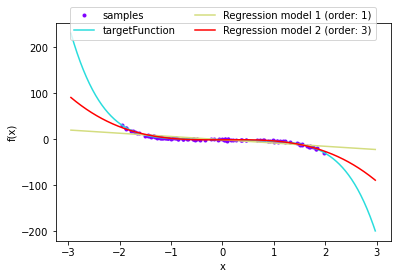

In [6]:
regressionLinesSimulation(targFuncOrder=5, polyOrders=[1,3], numTrainSamps=100, numTestSamps=100, plotLines=True, 
    printTableOfRegMSEs=True, x_dist='uniform', x_ub=2, x_lb=-2, rngSeed=-1)